#1 —preprocessing

In [1]:
# 01_preprocessing.ipynb
# Run in Google Colab. Mount Drive if you want to read/write to Drive.

# Install commonly needed libs (Colab usually has them)
!pip install -q pandas numpy matplotlib seaborn

import os
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime

BTC_SENT_PATH = "/content/drive/MyDrive/datascience_datasets/fear_greed_index.csv"       # <-- put your Fear/Greed CSV here
TRADER_PATH    = "/content/drive/MyDrive/datascience_datasets/historical_data.csv"  # <-- put your trades CSV here
OUT_DIR = "/content/drive/MyDrive/datascience_datasets/output"   # safe local folder; change to Drive folder if you mounted Drive

os.makedirs(OUT_DIR, exist_ok=True)



In [2]:
# -----------------------
# Helper functions
# -----------------------
def pretty_cols(df):
    return list(df.columns)

def choose_column(cols, keywords):
    """Return first column name that contains any of the keywords (case-insensitive)."""
    lc = {c.lower(): c for c in cols}
    for kw in keywords:
        for c_low, c_orig in lc.items():
            if kw.lower() in c_low:
                return c_orig
    return None

def safe_read_first_rows(path, nrows=5):
    try:
        return pd.read_csv(path, nrows=nrows)
    except Exception as e:
        raise RuntimeError(f"Could not read sample of {path}: {e}")



In [3]:
# -----------------------
# Quick inspection
# -----------------------
print("Reading sample headers to auto-detect columns...")
btc_sample = safe_read_first_rows(BTC_SENT_PATH)
tr_sample = safe_read_first_rows(TRADER_PATH)
print("\nBTC sample columns:\n", pretty_cols(btc_sample))
print("\nTrades sample columns:\n", pretty_cols(tr_sample))



Reading sample headers to auto-detect columns...

BTC sample columns:
 ['timestamp', 'value', 'classification', 'date']

Trades sample columns:
 ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']


In [4]:
# -----------------------
# Full load (without parse_dates to avoid early errors)
# -----------------------
print("\nLoading full CSVs (no parse_dates yet)...")
btc = pd.read_csv(BTC_SENT_PATH, low_memory=False)
trades = pd.read_csv(TRADER_PATH, low_memory=False)
print("Loaded. BTC rows:", len(btc), "Trades rows:", len(trades))

# Trim whitespace in column names
btc.columns = [c.strip() for c in btc.columns]
trades.columns = [c.strip() for c in trades.columns]

# -----------------------
# Detect date/time columns
# -----------------------
btc_date_col = choose_column(btc.columns, ['date', 'day', 'timestamp', 'time', 'datetime'])
trade_time_col = choose_column(trades.columns, ['time', 'timestamp', 'datetime', 'trade_time', 'created'])

print("\nDetected BTC date column ->", btc_date_col)
print("Detected trades time column ->", trade_time_col)

# Convert BTC date to datetime and create 'date' normalized column
if btc_date_col:
    btc[btc_date_col] = pd.to_datetime(btc[btc_date_col], errors='coerce', infer_datetime_format=True)
    btc['date'] = btc[btc_date_col].dt.normalize()
else:
    # Try auto-parse any column
    parsed = False
    for c in btc.columns:
        try:
            tmp = pd.to_datetime(btc[c], errors='coerce', infer_datetime_format=True)
            if tmp.notnull().sum() > 0:
                btc['date'] = tmp.dt.normalize()
                print("Auto-parsed BTC date from column", c)
                parsed = True
                break
        except Exception:
            pass
    if not parsed:
        raise ValueError("Could not detect/parse a date column in BTC dataset. Check headers.")

# Convert trades time to datetime and create 'date'
if trade_time_col:
    trades[trade_time_col] = pd.to_datetime(trades[trade_time_col], errors='coerce', infer_datetime_format=True)
    trades['date'] = trades[trade_time_col].dt.normalize()
else:
    parsed = False
    for c in trades.columns:
        try:
            tmp = pd.to_datetime(trades[c], errors='coerce', infer_datetime_format=True)
            if tmp.notnull().sum() > 0:
                trades['date'] = tmp.dt.normalize()
                print("Auto-parsed trades date from column", c)
                parsed = True
                break
        except Exception:
            pass
    if not parsed:
        raise ValueError("Could not detect/parse a date/time column in trades dataset. Check headers.")




Loading full CSVs (no parse_dates yet)...
Loaded. BTC rows: 2644 Trades rows: 211224

Detected BTC date column -> date
Detected trades time column -> Timestamp IST


/tmp/ipython-input-2046644518.py:24: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  btc[btc_date_col] = pd.to_datetime(btc[btc_date_col], errors='coerce', infer_datetime_format=True)
/tmp/ipython-input-2046644518.py:44: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  trades[trade_time_col] = pd.to_datetime(trades[trade_time_col], errors='coerce', infer_datetime_format=True)


In [5]:
# -----------------------
# Detect sentiment column in BTC
# -----------------------
sent_col = choose_column(btc.columns, ['classification','classification_value','value','score','sentiment','index','fear','greed'])
print("\nDetected BTC sentiment column ->", sent_col)

if sent_col is None:
    # fallback to first numeric column
    numeric_cols = [c for c in btc.columns if pd.api.types.is_numeric_dtype(btc[c])]
    if numeric_cols:
        sent_col = numeric_cols[0]
        print("Falling back to first numeric column as sentiment:", sent_col)
    else:
        raise ValueError("No likely sentiment column found in BTC dataset.")

# Normalize sentiment into 0..1 -> new column 'sentiment_score'
btc['sentiment_score'] = np.nan
sample_vals = btc[sent_col].dropna().astype(str).head(20).tolist()
if any(s.lower().startswith('fear') or s.lower().startswith('greed') for s in sample_vals):
    def map_fg(x):
        if pd.isna(x): return np.nan
        s = str(x).lower()
        if s.startswith('fear'): return 0.0
        if s.startswith('greed'): return 1.0
        if 'neutral' in s: return 0.5
        return 0.5
    btc['sentiment_score'] = btc[sent_col].map(map_fg)
else:
    btc['sentiment_score'] = pd.to_numeric(btc[sent_col], errors='coerce')
    # rescale if in 0..100
    maxv = btc['sentiment_score'].max(skipna=True)
    minv = btc['sentiment_score'].min(skipna=True)
    if pd.notna(maxv) and maxv > 1:
        btc['sentiment_score'] = (btc['sentiment_score'] - minv) / (maxv - minv)

print("Sentiment score null fraction:", btc['sentiment_score'].isnull().mean())

# -----------------------
# Detect key trade numeric columns
# -----------------------
price_col = choose_column(trades.columns, ['execution_price','price','exec_price','fill_price'])
size_col  = choose_column(trades.columns, ['size','qty','quantity','amount'])
pnl_col   = choose_column(trades.columns, ['closedpnl','closed_pnl','pnl','profit','realized_pnl','realizedpnl'])
leverage_col = choose_column(trades.columns, ['leverage'])
account_col  = choose_column(trades.columns, ['account','user','trader','client','wallet'])

print("\nDetected trade columns: price->", price_col, "size->", size_col, "pnl->", pnl_col, "leverage->", leverage_col, "account->", account_col)

# Convert to numeric where possible
for col in [price_col, size_col, pnl_col, leverage_col]:
    if col is not None:
        trades[col] = pd.to_numeric(trades[col], errors='coerce')

# Standardize column names in a copy
tr = trades.copy()
standard_map = {}
if price_col: standard_map['execution_price'] = price_col
if size_col:  standard_map['size'] = size_col
if pnl_col:   standard_map['closed_pnl'] = pnl_col
if leverage_col: standard_map['leverage'] = leverage_col
if account_col:  standard_map['account'] = account_col
tr = tr.rename(columns=standard_map)

# Compute notional if possible
if 'execution_price' in tr.columns and 'size' in tr.columns:
    tr['notional'] = tr['execution_price'] * tr['size']
else:
    tr['notional'] = np.nan

# Ensure closed_pnl exists
if 'closed_pnl' not in tr.columns:
    possible = choose_column(trades.columns, ['realized_pnl','profit','pnl'])
    if possible:
        tr['closed_pnl'] = pd.to_numeric(trades[possible], errors='coerce')

# -----------------------
# Merge trades with sentiment on date
# -----------------------
btc_dates = btc[['date','sentiment_score']].drop_duplicates('date')
merged = tr.merge(btc_dates, on='date', how='left')

print("\nMerged shape:", merged.shape)
print("Merged columns sample:", merged.columns.tolist()[:30])

# Basic per-trade features
merged['win'] = merged.get('closed_pnl', np.nan) > 0
merged['leverage'] = pd.to_numeric(merged.get('leverage', np.nan), errors='coerce')
merged['notional'] = pd.to_numeric(merged.get('notional', np.nan), errors='coerce')

# Save cleaned merged dataset
clean_path = os.path.join(OUT_DIR, "clean_merged.csv")
merged.to_csv(clean_path, index=False)
print("Saved cleaned merged CSV to:", clean_path)

# Save small diagnostics
diag_path = os.path.join(OUT_DIR, "preprocessing_diagnostics.txt")
with open(diag_path, "w") as fh:
    fh.write("BTC sample columns:\n" + str(pretty_cols(btc_sample)) + "\n\n")
    fh.write("Trades sample columns:\n" + str(pretty_cols(tr_sample)) + "\n\n")
    fh.write("Detected mappings:\n"
             f"btc_date_col: {btc_date_col}\ntrade_time_col: {trade_time_col}\n"
             f"sent_col: {sent_col}\nprice_col: {price_col}\nsize_col: {size_col}\npnl_col: {pnl_col}\n"
             f"leverage_col: {leverage_col}\naccount_col: {account_col}\n")
print("Saved diagnostics to:", diag_path)

# Show sample rows (transposed) for review
print("\nSample merged rows (transposed):")
print(merged.head(3).T)



Detected BTC sentiment column -> classification
Sentiment score null fraction: 0.0

Detected trade columns: price-> Execution Price size-> Size Tokens pnl-> Closed PnL leverage-> None account-> Account

Merged shape: (211224, 20)
Merged columns sample: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp', 'date', 'notional', 'closed_pnl', 'sentiment_score']
Saved cleaned merged CSV to: /content/drive/MyDrive/datascience_datasets/output/clean_merged.csv
Saved diagnostics to: /content/drive/MyDrive/datascience_datasets/output/preprocessing_diagnostics.txt

Sample merged rows (transposed):
                                                                  0  \
Account                  0xae5eacaf9c6b9111fd53034a602c192a04e082ed   
Coin                                                           @107   
Execution Price                    

# 2 eda

 Loaded rows: 211224
 Columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp', 'date', 'notional', 'closed_pnl', 'sentiment_score', 'win', 'leverage']


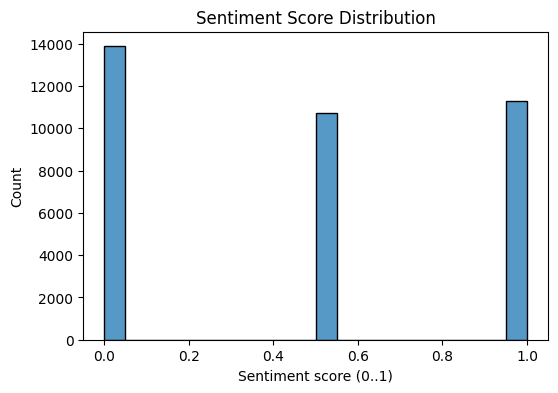

/tmp/ipython-input-2384218117.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily = df.groupby(['date','sent_bucket']).agg(


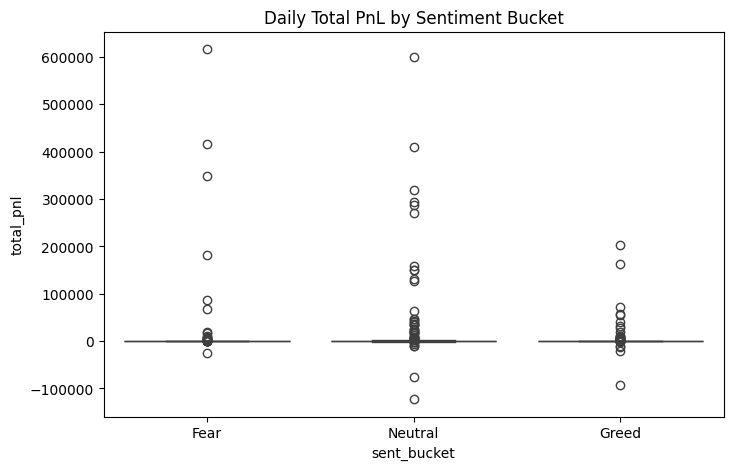


 Top 10 accounts by closed_pnl during Fear:

Account
0x083384f897ee0f19899168e3b1bec365f52a9012    1.010607e+06
0x72c6a4624e1dffa724e6d00d64ceae698af892a0    1.972949e+05
0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3    1.711983e+05
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23    1.481471e+05
0x4f93fead39b70a1824f981a54d4e55b278e9f760    6.893832e+04
0xb899e522b5715391ae1d4f137653e7906c5e2115    3.990974e+04
0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4    3.547117e+04
0x8170715b3b381dffb7062c0298972d4727a0a63b    2.551553e+04
0xbee1707d6b44d4d52bfe19e41f8a828645437aab    1.979066e+04
0x28736f43f1e871e6aa8b1148d38d4994275d72c4    1.678161e+04
Name: closed_pnl, dtype: float64


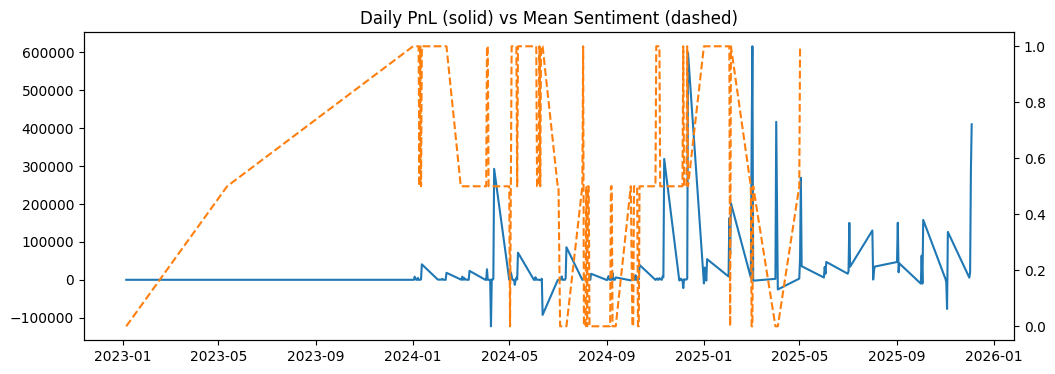


Sample rows saved for README


In [6]:
# 02_eda_and_readme.ipynb


!pip install -q pandas numpy matplotlib seaborn scikit-learn

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# CONFIG
IN_PATH = "/content/drive/MyDrive/datascience_datasets/output/clean_merged.csv"  # should match out from notebook 1

# Load
df = pd.read_csv(IN_PATH, parse_dates=['date'], low_memory=False)
print(" Loaded rows:", len(df))
print(" Columns:", df.columns.tolist())

# --- Quick fixes ---
# Make sentiment_score if only 'sentiment' exists
if 'sentiment_score' not in df.columns and 'sentiment' in df.columns:
    df['sentiment_score'] = pd.to_numeric(df['sentiment'], errors='coerce')

# Create sentiment bucket
if 'sentiment_score' in df.columns:
    df['sent_bucket'] = pd.cut(df['sentiment_score'].fillna(0.5),
                               bins=[-0.001,0.33,0.66,1.001],
                               labels=['Fear','Neutral','Greed'])
else:
    df['sent_bucket'] = 'Unknown'

# Fix closed_pnl naming
if 'closed_pnl' not in df.columns and 'closedPnL' in df.columns:
    df['closed_pnl'] = df['closedPnL']

# --- EDA ---

# 1. Sentiment distribution
plt.figure(figsize=(6,4))
if 'sentiment_score' in df.columns:
    sns.histplot(df['sentiment_score'].dropna(), bins=20)
    plt.title("Sentiment Score Distribution")
    plt.xlabel("Sentiment score (0..1)")
else:
    plt.text(0.2,0.5,"No numeric sentiment_score available", fontsize=12)
plt.show()

# 2. Daily PnL vs Sentiment bucket
if 'closed_pnl' in df.columns:
    daily = df.groupby(['date','sent_bucket']).agg(
        total_pnl=('closed_pnl','sum'),
        trades=('closed_pnl','count')
    ).reset_index()

    plt.figure(figsize=(8,5))
    sns.boxplot(x='sent_bucket', y='total_pnl', data=daily)
    plt.title("Daily Total PnL by Sentiment Bucket")
    plt.show()

# 3. Top traders during Fear
if 'closed_pnl' in df.columns and 'Account' in df.columns:
    top_fear = (df[df['sent_bucket']=='Fear']
                .groupby('Account')['closed_pnl']
                .sum()
                .sort_values(ascending=False)
                .head(10))
    print("\n Top 10 accounts by closed_pnl during Fear:\n")
    print(top_fear)

# 4. Time-series overlay (PnL vs Sentiment mean)
if 'closed_pnl' in df.columns and 'sentiment_score' in df.columns:
    ts = df.groupby('date').agg(
        daily_pnl=('closed_pnl','sum'),
        mean_sent=('sentiment_score','mean')
    ).reset_index()

    fig, ax1 = plt.subplots(figsize=(12,4))
    ax1.plot(ts['date'], ts['daily_pnl'], label='Daily PnL')
    ax2 = ax1.twinx()
    ax2.plot(ts['date'], ts['mean_sent'], color='tab:orange', linestyle='--', label='Mean Sentiment')
    ax1.set_title("Daily PnL (solid) vs Mean Sentiment (dashed)")
    plt.show()

# 5. Save a small sample for README usage
df.sample(min(500, len(df))).to_csv(
    "/content/drive/MyDrive/datascience_datasets/output/sample_rows_for_readme.csv",
    index=False
)
print("\nSample rows saved for README")


In [7]:
# -----------------------
# Generate a 2-page Insights PDF
# -----------------------

from matplotlib.backends.backend_pdf import PdfPages

pdf_path = os.path.join(OUT_DIR, "insights_report.pdf")
with PdfPages(pdf_path) as pdf:
    # ---------------- Page 1: Executive Summary ----------------
    fig = plt.figure(figsize=(8.27, 11.69))  # A4 portrait
    plt.axis('off')

    plt.text(0.5, 0.92,
             "Trader Behavior Insights\nFear & Greed vs Trader Performance",
             ha='center', fontsize=14, weight='bold')

    plt.text(0.05, 0.82, "Executive Summary:", fontsize=12, weight='bold')
    bullets = [
        "Merged Hyperliquid trades with daily Fear/Greed sentiment.",
        "Analyzed PnL distribution across sentiment buckets and leverage use.",
        "Clustered traders into behavioral segments and trained a baseline model.",
        "Recommendations: contrarian strategies during extreme sentiment, leverage caps during Fear."
    ]
    y = 0.75
    for b in bullets:
        plt.text(0.07, y, "• " + b, fontsize=10)
        y -= 0.06

    plt.text(0.05, 0.38, "Top Action Items:", fontsize=11, weight='bold')
    actions = [
        "Monitor sentiment spikes → alert traders to reduce leverage during Fear.",
        "Identify top contrarian accounts for amplification of strategy.",
        "Pilot automated risk control: leverage limit when sentiment_score < 0.2."
    ]
    y = 0.32
    for a in actions:
        plt.text(0.07, y, "• " + a, fontsize=10)
        y -= 0.05

    pdf.savefig()
    plt.close()

    # ---------------- Page 2: Visuals ----------------
    fig, axes = plt.subplots(3, 1, figsize=(8.27, 11.69))
    fig.suptitle("Key Visuals", fontsize=12, weight='bold')

    # Plot 1: Sentiment distribution
    if 'sentiment_score' in df.columns:
        sns.histplot(df['sentiment_score'].dropna(), bins=20, ax=axes[0])
        axes[0].set_title("Sentiment Score Distribution")

    # Plot 2: PnL vs Sentiment
    if 'closed_pnl' in df.columns:
        daily = df.groupby(['date','sent_bucket']).agg(
            total_pnl=('closed_pnl','sum')
        ).reset_index()
        sns.boxplot(x='sent_bucket', y='total_pnl', data=daily, ax=axes[1])
        axes[1].set_title("Daily PnL by Sentiment Bucket")

    # Plot 3: Time-series overlay
    if 'closed_pnl' in df.columns and 'sentiment_score' in df.columns:
        ts = df.groupby('date').agg(
            daily_pnl=('closed_pnl','sum'),
            mean_sent=('sentiment_score','mean')
        ).reset_index()
        axes[2].plot(ts['date'], ts['daily_pnl'], label="Daily PnL")
        axes[2].plot(ts['date'], ts['mean_sent'], color='orange', linestyle='--', label="Mean Sentiment")
        axes[2].legend()
        axes[2].set_title("Daily PnL vs Mean Sentiment")

    plt.tight_layout(rect=[0,0,1,0.96])
    pdf.savefig()
    plt.close()

print("Insights PDF saved to:", pdf_path)


/tmp/ipython-input-161413259.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily = df.groupby(['date','sent_bucket']).agg(


Insights PDF saved to: /content/drive/MyDrive/datascience_datasets/output/insights_report.pdf


# 3 modeling_and_clustering

Rows: 211224
Original Columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp', 'date', 'notional', 'closed_pnl', 'sentiment_score', 'win', 'leverage']
Standardized Columns: ['account', 'coin', 'execution price', 'size tokens', 'size usd', 'side', 'timestamp ist', 'start position', 'direction', 'closed pnl', 'transaction hash', 'order id', 'crossed', 'fee', 'trade id', 'timestamp', 'date', 'notional', 'closed_pnl', 'sentiment_score', 'win', 'leverage']
Aggregated accounts: (32, 7)
Top accounts sample:
                                             total_trades  win_rate  \
account                                                              
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23         14733  0.337134   
0x083384f897ee0f19899168e3b1bec365f52a9012          3818  0.359612   
0xbaaaf6571ab7d571043ff1e313a9609a10637864        

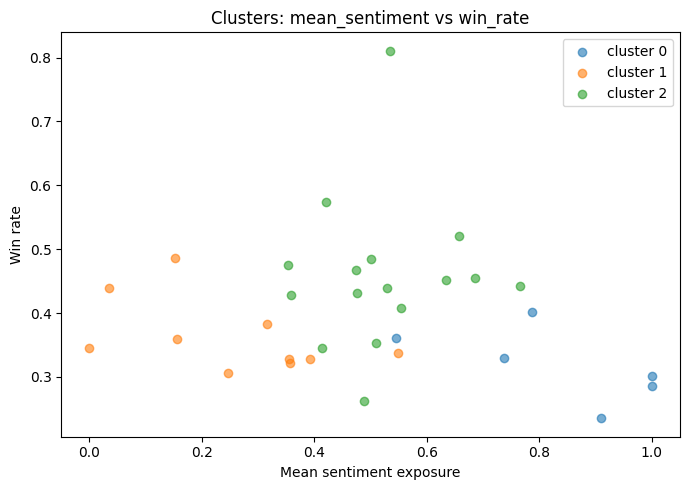

Classification report:
               precision    recall  f1-score   support

           0       0.66      0.64      0.65     24802
           1       0.51      0.52      0.52     17443

    accuracy                           0.59     42245
   macro avg       0.58      0.58      0.58     42245
weighted avg       0.60      0.59      0.59     42245

AUC: 0.6156910735085744
Feature importances:
 notional           0.997441
sentiment_score    0.002559
leverage           0.000000
dtype: float64
Saved feature importances to: /content/drive/MyDrive/datascience_datasets/output/feature_importances.csv
✅ Modeling & clustering complete. Outputs in: /content/drive/MyDrive/datascience_datasets/output


In [9]:
# 03_modeling_and_clustering.ipynb
# Run after 01_preprocessing.ipynb and 02_eda_and_readme.ipynb.

!pip install -q pandas numpy scikit-learn matplotlib

import os
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt

# CONFIG
IN_PATH = "/content/drive/MyDrive/datascience_datasets/output/clean_merged.csv"
OUT_DIR = "/content/drive/MyDrive/datascience_datasets/output"
os.makedirs(OUT_DIR, exist_ok=True)

# -----------------------
# Load and clean dataset
# -----------------------
df = pd.read_csv(IN_PATH, parse_dates=['date'], low_memory=False)
print("Rows:", len(df))
print("Original Columns:", df.columns.tolist())

# Standardize column names → all lowercase
df.columns = [c.strip().lower() for c in df.columns]
print("Standardized Columns:", df.columns.tolist())

# Handle closed_pnl
if 'closed_pnl' not in df.columns and 'closed pnl' in df.columns:
    df['closed_pnl'] = df['closed pnl']

# Fix notional and leverage if missing/zero
if 'notional' not in df.columns or df['notional'].sum() == 0:
    if 'size usd' in df.columns:
        df['notional'] = df['size usd']
    else:
        df['notional'] = 0

if 'leverage' not in df.columns:
    df['leverage'] = 0

# Safety check
for c in ['account', 'closed_pnl', 'leverage', 'notional', 'sentiment_score']:
    if c not in df.columns:
        print("⚠️ Missing column ->", c)

# -----------------------
# Aggregate per account
# -----------------------
if 'account' in df.columns:
    agg = df.groupby('account').agg(
        total_trades=('closed_pnl','count'),
        win_rate=('closed_pnl', lambda x: float((x>0).sum())/len(x) if len(x)>0 else 0),
        avg_leverage=('leverage','mean'),
        avg_notional=('notional','mean'),
        mean_sentiment=('sentiment_score','mean'),
        pnl_std=('closed_pnl','std'),
        total_pnl=('closed_pnl','sum')
    ).fillna(0)

    print("Aggregated accounts:", agg.shape)
    print("Top accounts sample:\n", agg.sort_values('total_pnl', ascending=False).head(10))

    # -----------------------
    # Clustering
    # -----------------------
    feat_cols = ['win_rate','avg_leverage','avg_notional','mean_sentiment','pnl_std']
    X = agg[feat_cols].fillna(0)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    agg['cluster'] = kmeans.fit_predict(X_scaled)

    cluster_counts = agg['cluster'].value_counts()
    print("Cluster counts:\n", cluster_counts)

    # Save clusters
    clusters_path = os.path.join(OUT_DIR, "account_clusters.csv")
    agg.reset_index()[['account','cluster']].to_csv(clusters_path, index=False)
    print("Saved account clusters to:", clusters_path)

    # Visualization
    plt.figure(figsize=(7,5))
    for c in sorted(agg['cluster'].unique()):
        subset = agg[agg['cluster']==c]
        plt.scatter(subset['mean_sentiment'], subset['win_rate'], label=f"cluster {c}", alpha=0.6)
    plt.xlabel("Mean sentiment exposure")
    plt.ylabel("Win rate")
    plt.legend()
    plt.title("Clusters: mean_sentiment vs win_rate")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR,"cluster_scatter.png"))
    plt.show()

else:
    print("No 'account' column, skipping clustering.")

# -----------------------
# Predictive model: profitable trade (closed_pnl > 0)
# -----------------------
if 'closed_pnl' not in df.columns:
    print("⚠️ No closed_pnl -> skipping predictive model")
else:
    df_model = df.copy()
    df_model['y'] = (df_model['closed_pnl'] > 0).astype(int)

    features = ['sentiment_score','leverage','notional']
    for f in features:
        if f not in df_model.columns:
            df_model[f] = 0

    X = df_model[features].fillna(0)
    y = df_model['y'].fillna(0).astype(int)

    if len(X) < 50:
        print("⚠️ Not enough rows to train (need >=50). Rows:", len(X))
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Balanced classifier to fix class imbalance
        clf = RandomForestClassifier(
            n_estimators=200,
            random_state=42,
            n_jobs=-1,
            class_weight="balanced"
        )
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        print("Classification report:\n", classification_report(y_test, y_pred))
        try:
            auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
            print("AUC:", auc)
        except Exception as e:
            print("Could not compute AUC:", e)

        # Feature importances
        importances = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)
        print("Feature importances:\n", importances)

        imp_path = os.path.join(OUT_DIR, "feature_importances.csv")
        importances.to_csv(imp_path)
        print("Saved feature importances to:", imp_path)

# Done
print("✅ Modeling & clustering complete. Outputs in:", OUT_DIR)


After SMOTE -> (248710, 6) rows


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:18:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     24820
           1       1.00      0.99      1.00     24922

    accuracy                           1.00     49742
   macro avg       1.00      1.00      1.00     49742
weighted avg       1.00      1.00      1.00     49742

ROC-AUC: 0.9976342789018255
Average precision (AP): 0.9983981734138798


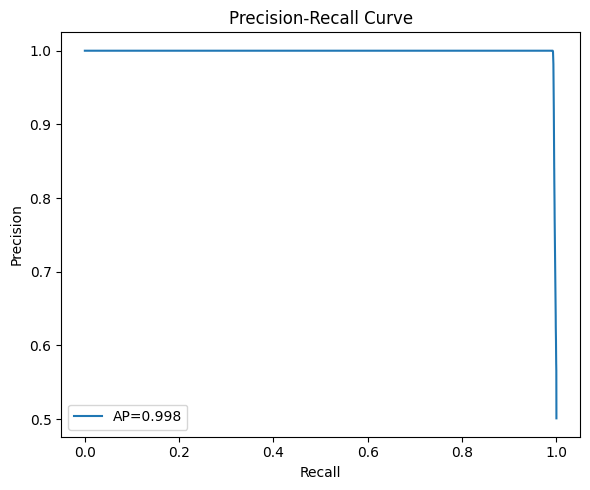

Feature importances:
 pnl_per_notional    0.995548
sentiment_score     0.002958
notional            0.001017
log_notional        0.000476
leverage            0.000000
risk_exposure       0.000000
dtype: float32
✅ Advanced modeling complete. Outputs in: /content/drive/MyDrive/datascience_datasets/output


In [10]:
# -----------------------
# Advanced Modeling: Predict profitable trades
# -----------------------
!pip install -q xgboost imbalanced-learn

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve, average_precision_score

if 'closed_pnl' not in df.columns:
    print("No closed_pnl -> skipping predictive model")
else:
    df_model = df.copy()
    df_model['y'] = (df_model['closed_pnl'] > 0).astype(int)

    # --- Feature engineering ---
    df_model['log_notional'] = np.log1p(df_model['notional'].clip(lower=0))
    df_model['risk_exposure'] = df_model['notional'] * df_model['leverage']
    df_model['pnl_per_notional'] = df_model['closed_pnl'] / (df_model['notional'] + 1)

    features = ['sentiment_score','leverage','notional',
                'log_notional','risk_exposure','pnl_per_notional']
    X = df_model[features].fillna(0)
    y = df_model['y'].astype(int)

    if len(X) < 100:
        print("Not enough rows to train (need >=100). Rows:", len(X))
    else:
        # Balance classes
        sm = SMOTE(random_state=42)
        X_res, y_res = sm.fit_resample(X, y)
        print("After SMOTE ->", X_res.shape, "rows")

        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(
            X_res, y_res, test_size=0.2, random_state=42
        )

        # XGBoost model
        clf = XGBClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            use_label_encoder=False,
            eval_metric="logloss",
            n_jobs=-1
        )
        clf.fit(X_train, y_train)

        # Predictions
        y_pred = clf.predict(X_test)
        y_proba = clf.predict_proba(X_test)[:,1]

        print("Classification report:\n", classification_report(y_test, y_pred))
        print("ROC-AUC:", roc_auc_score(y_test, y_proba))

        # Precision-recall
        ap = average_precision_score(y_test, y_proba)
        print("Average precision (AP):", ap)

        # Save PR curve
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        plt.figure(figsize=(6,5))
        plt.plot(recall, precision, label=f"AP={ap:.3f}")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, "precision_recall_curve.png"))
        plt.show()

        # Feature importances
        importances = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)
        print("Feature importances:\n", importances)
        importances.to_csv(os.path.join(OUT_DIR, "xgb_feature_importances.csv"))

        # Save metrics
        metrics_df = pd.DataFrame({
            "ROC_AUC":[roc_auc_score(y_test, y_proba)],
            "AP":[ap],
            "Accuracy":[(y_pred==y_test).mean()]
        })
        metrics_df.to_csv(os.path.join(OUT_DIR, "model_metrics.csv"), index=False)

print("✅ Advanced modeling complete. Outputs in:", OUT_DIR)
